###Import the stuff

In [1]:
import sys

In [2]:
sys.path.append("C:\Users\Miguel\workspace\Thesis\geobyes")

In [3]:
import geobayes_simple as gs
from matplotlib import pyplot as plt


In [4]:
%matplotlib inline
import pymc as pm
from pymc.Matplot import plot
import numpy as np
import daft
from IPython.core.pylabtools import figsize
figsize(12.5, 10)

Couldn't import dot_parser, loading of dot files will not be possible.


##### Normal distributions

A Normal random variable, denoted $X \sim N(\mu, 1/\tau)$, has a distribution with two parameters: the mean, $\mu$, and the *precision*, $\tau$. Those familiar with the Normal distribution already have probably seen $\sigma^2$ instead of $\tau^{-1}$. They are in fact reciprocals of each other. The change was motivated by simpler mathematical analysis and is an artifact of older Bayesian methods. Just remember: the smaller $\tau$, the larger the spread of the distribution (i.e. we are more uncertain); the larger $\tau$, the tighter the distribution (i.e. we are more certain). Regardless, $\tau$ is always positive. 

The probability density function of a $N( \mu, 1/\tau)$ random variable is:

$$ f(x | \mu, \tau) = \sqrt{\frac{\tau}{2\pi}} \exp\left( -\frac{\tau}{2} (x-\mu)^2 \right) $$


The conversion deviation precision is somehow -> 1.0 / data_std[0] ** 2)

### Simplest case: three horizontal layers, with depth unknow
####Setting priors



In [14]:
alpha = pm.Normal("alpha", 0, 0.5, value= 5)
beta = pm.Normal("beta", -200, 0.005, value=0)
gamma = pm.Normal("gamma", -300, 0.005, value = 0)


#MODEL!!
model = pm.Model([alpha, beta, gamma])

####Pymc simulation

In [15]:
M = pm.MCMC(model)
C = pm.MAP(model)
M.sample(iter=1000, burn = 800)


 [-----------------100%-----------------] 1000 of 1000 complete in 0.1 sec

In [13]:
gamma.logp

-3.5709824979398315

#### Representation

In [16]:
alpha_samples = M.trace('alpha')[:]
beta_samples = M.trace('beta')[:]
gamma_samples = M.trace('gamma')[:]

alpha_samples, alpha_samples_all = M.trace('alpha')[-80:], M.trace("alpha")[:]
beta_samples, beta_samples_all = M.trace('beta')[-80:], M.trace("beta")[:]
gamma_samples, gamma_samples_all = M.trace('gamma')[-80:], M.trace('gamma')[:]

parameters = zip(alpha_samples, beta_samples, gamma_samples)
parameters_all = zip(alpha_samples_all, beta_samples_all, gamma_samples_all)

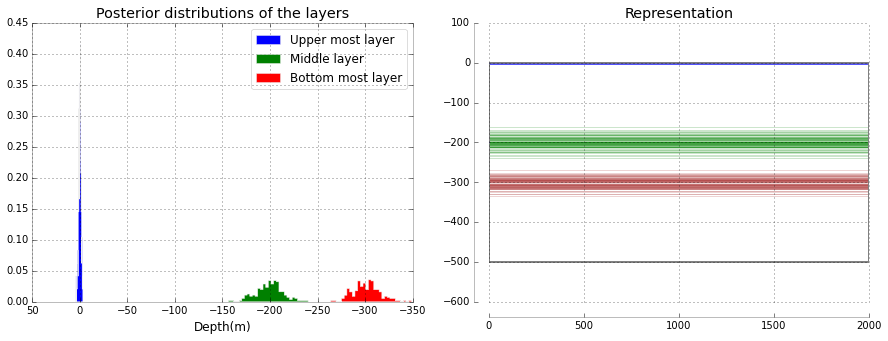

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].hist(alpha_samples_all, histtype='stepfilled', bins=30, alpha=1,
         label="Upper most layer", normed=True, color = "b")
ax[0].hist(beta_samples_all, histtype='stepfilled', bins=30, alpha=1,
         label="Middle layer", normed=True, color = "g")
ax[0].hist(gamma_samples_all, histtype='stepfilled', bins=30, alpha=1,
         label="Bottom most layer", normed=True, color = "r")


ax[0].invert_xaxis()
ax[0].legend()
ax[0].set_title(r"""Posterior distributions of the layers""")
ax[0].set_xlabel("Depth(m)")


ax[1].set_title("Representation")
ax[1].set_xlim([0,2000])
for alpha, beta, gamma in parameters:
    #print alpha, beta, gamma
    model_parameters = {'faults' : {'fault_w_pos' : (0,0.),
                                    'fault_w_dip' : 0,
                                    'fault_e_pos' : (0.,0.),
                                    'fault_e_dip' : 0.},
                        'layers' : {3 : {'w' :(250., -200.),
                                         
                                                 'c' : (1000., -400.),
                                                 'e' : (1750., alpha)},
                                    2 : {'w' :(250., -400.),
                                                 'c' : (1000., -600.),
                                                 'e' : (1750., beta)},
                                    1 : {'w' :(250., -600.),
                                                 'c' : (1000., -800.),
                                                 'e' : (1750., gamma)}},
                        'layer_dip' : 0.000001,
                        'layer_colors' : {1 : 'Brown', 2 : 'g', 3 : 'b'},
                        'width' : 2000., # [m]
                        'height' : 500. # [m]
                        }
    GM = gs.GrabenModel(model_parameters)
    GM.plot_model(ax = ax[1], plot_faults= False, plot_points= False, alpha = 0.3) # Need to make it transparent!!!

In [18]:
M.summary()


beta:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	[[-199.325]]     [[ 14.242]]      [[ 0.935]]   [-226.38  -170.499]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	[[-228.48]]      [[-207.743]]    [[-199.625]]   [[-190.329]]  [[-170.686]]
	

gamma:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	[[-301.664]]     [[ 13.89]]       [[ 1.044]]   [-328.367 -277.403]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	[[-329.475]]     [[-310.288]]    [[-301.306]]   [[-292.59]]   [[-277.956]]
	

alpha:
 
	Mean             SD               MC Error        95% HPD interval
	--------

Plotting beta
Plotting alpha
Plotting gamma


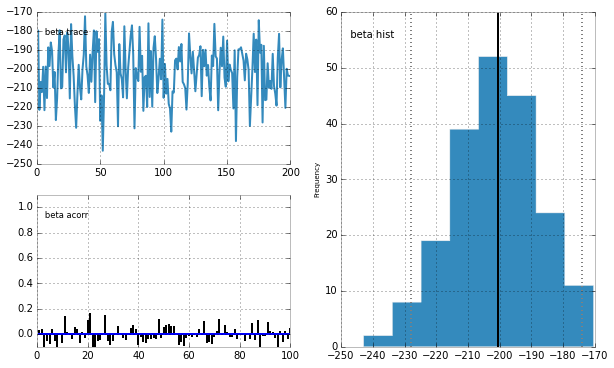

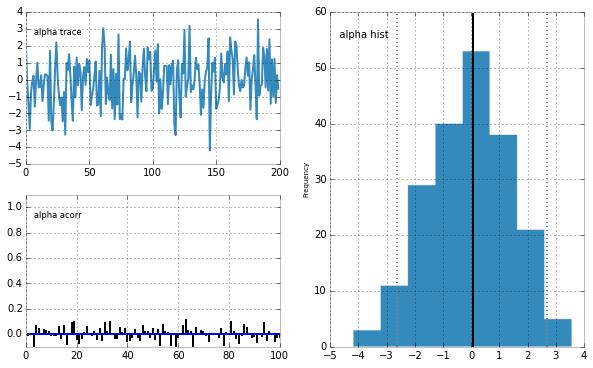

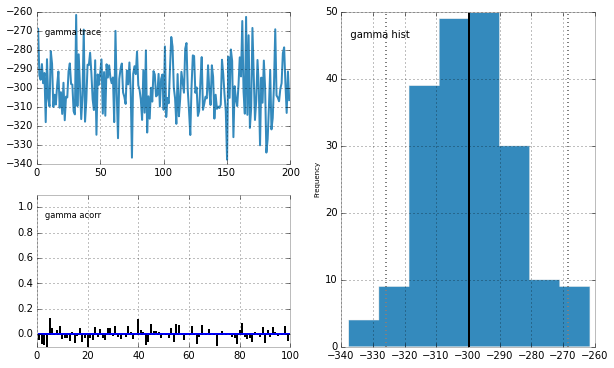

In [9]:
plot(M)

###Tickness of layers known
####Setting priors

In [24]:
alpha = pm.Normal("alpha", 0, 0.5)

thickness_layer1 = pm.Normal("thickness_layer1", 200, 0.005)
thickness_layer2 = pm.Normal("thickness_layer2", 100, 0.005)

@pm.deterministic
def beta(alpha = alpha, thickness_layer1 = thickness_layer1):
    return alpha - thickness_layer1


@pm.deterministic
def gamma(beta = beta, thickness_layer2 = thickness_layer2):
    return beta - thickness_layer2


#MODEL!!
model = pm.Model([alpha, beta, gamma, thickness_layer1, thickness_layer2])

####PyMC simulation

In [25]:
M = pm.MCMC(model)
M.sample(iter=5000, burn = 800)

 [-----------------100%-----------------] 5000 of 5000 complete in 0.6 sec

####Representation

In [26]:
alpha_samples = M.trace('alpha')[:]
beta_samples = M.trace('beta')[:]
gamma_samples = M.trace('gamma')[:]

alpha_samples, alpha_samples_all = M.trace('alpha')[-80:], M.trace("alpha")[:]
beta_samples, beta_samples_all = M.trace('beta')[-80:], M.trace("beta")[:]
gamma_samples, gamma_samples_all = M.trace('gamma')[-80:], M.trace('gamma')[:]

parameters = zip(alpha_samples, beta_samples, gamma_samples)
parameters_all = zip(alpha_samples_all, beta_samples_all, gamma_samples_all)

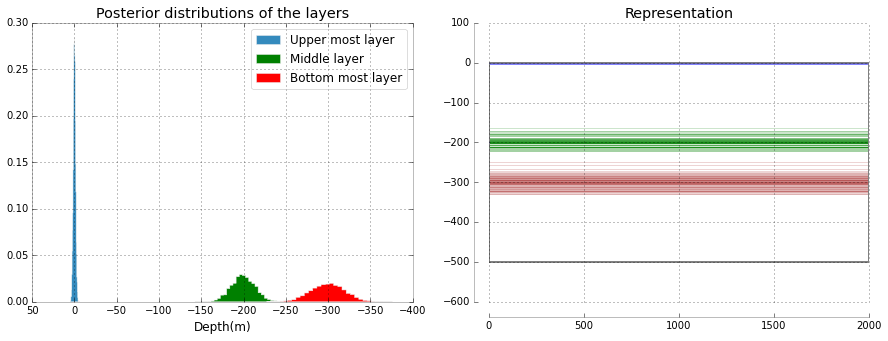

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].hist(alpha_samples_all, histtype='stepfilled', bins=30, alpha=1,
         label="Upper most layer", normed=True)
ax[0].hist(beta_samples_all, histtype='stepfilled', bins=30, alpha=1,
         label="Middle layer", normed=True, color = "g")
ax[0].hist(gamma_samples_all, histtype='stepfilled', bins=30, alpha=1,
         label="Bottom most layer", normed=True, color = "r")


ax[0].invert_xaxis()
ax[0].legend()
ax[0].set_title(r"""Posterior distributions of the layers""")
ax[0].set_xlabel("Depth(m)")


ax[1].set_title("Representation")
ax[1].set_xlim([0,2000])
for alpha, beta, gamma in parameters:
    #print alpha, beta, gamma
    model_parameters = {'faults' : {'fault_w_pos' : (0,0.),
                                    'fault_w_dip' : 0,
                                    'fault_e_pos' : (0.,0.),
                                    'fault_e_dip' : 0.},
                        'layers' : {3 : {'w' :(250., -200.),
                                         
                                                 'c' : (1000., -400.),
                                                 'e' : (1750., alpha)},
                                    2 : {'w' :(250., -400.),
                                                 'c' : (1000., -600.),
                                                 'e' : (1750., beta)},
                                    1 : {'w' :(250., -600.),
                                                 'c' : (1000., -800.),
                                                 'e' : (1750., gamma)}},
                        'layer_dip' : 0.000001,
                        'layer_colors' : {1 : 'Brown', 2 : 'g', 3 : 'b'},
                        'width' : 2000., # [m]
                        'height' : 500. # [m]
                        }
    GM = gs.GrabenModel(model_parameters)
    GM.plot_model(ax = ax[1], plot_faults= False, plot_points= False, alpha = 0.3) # Need to make it transparent!!!

Plotting thickness_layer2
Plotting thickness_layer1
Plotting beta
Plotting alpha
Plotting gamma


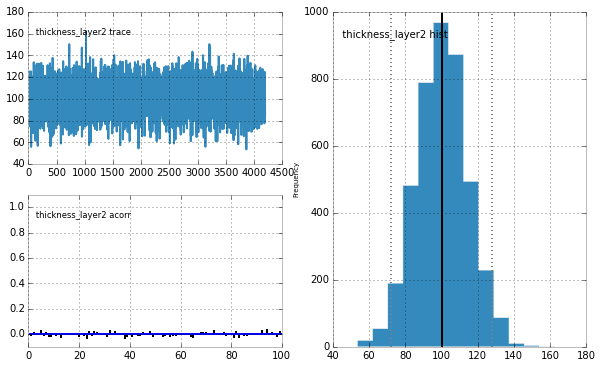

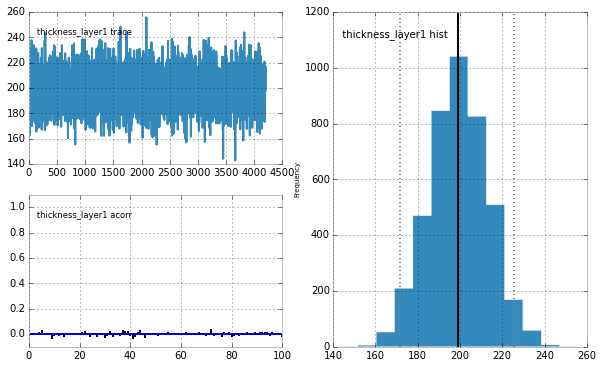

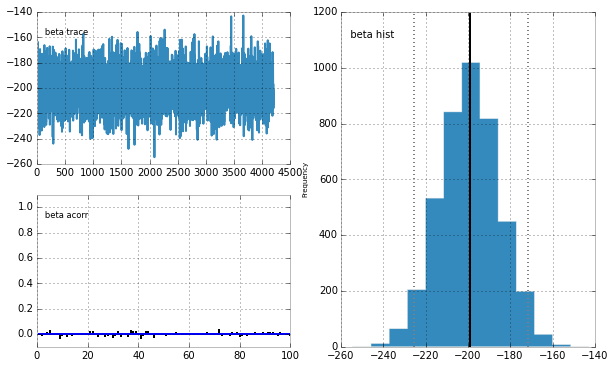

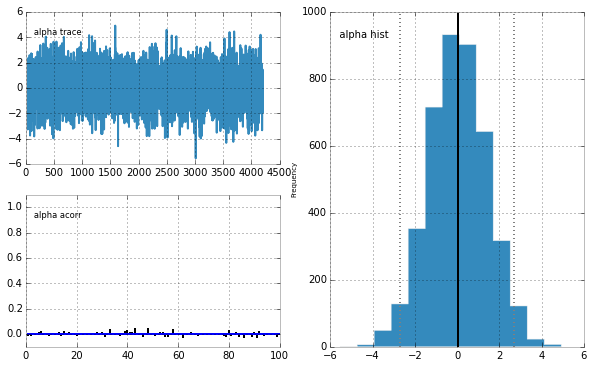

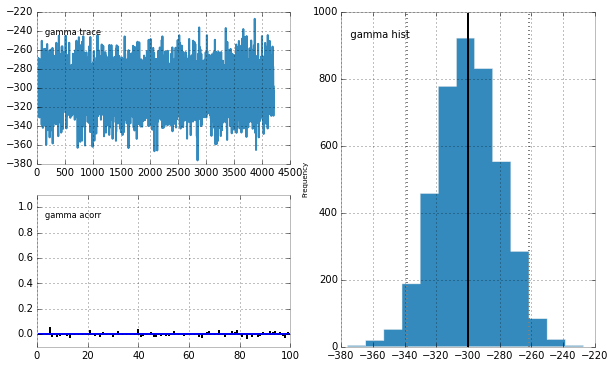

In [27]:
plot(M)

In [21]:
M.summary()


alpha:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	[[-0.021]]       [[ 1.433]]       [[ 0.022]]       [-2.968  2.671]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	[[-2.887]]       [[-0.966]]      [[-0.007]]     [[ 0.935]]    [[ 2.81]]
	

thickness_layer2:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	[[ 100.024]]     [[ 14.178]]      [[ 0.227]]   [  73.944  129.273]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	[[ 71.913]]      [[ 90.657]]     [[ 99.982]]    [[ 109.58]]   [[ 127.605]]
	

thickness_layer1:
 
	Mean             SD               MC Error        95% HP

### Adding complexity: Faults and slight inclination, no constraints

#### Setting priors and model

In [82]:
alpha = pm.Normal("alpha", 0, 0.5)

thickness_layer1 = pm.Normal("thickness_layer1", 200, 0.005)
thickness_layer2 = pm.Normal("thickness_layer2", 100, 0.005)

offset = pm.Normal("offset", 400, 0.05)
layer_dip = pm.Normal("layer_dip", 5, 0.05)

fault_e_dip = pm.Normal("fault_e_dip", -70, 0.00005)
fault_w_dip = pm.Normal("fault_w_dip", 70, 0.05)


@pm.deterministic
def beta(alpha = alpha, thickness_layer1 = thickness_layer1):
    return alpha - thickness_layer1


@pm.deterministic
def gamma(beta = beta, thickness_layer2 = thickness_layer2):
    return beta - thickness_layer2


#MODEL!!
model = pm.Model([alpha, beta, gamma, thickness_layer1, thickness_layer2, offset, layer_dip, fault_e_dip, fault_w_dip])

#### PyMC simulation

In [83]:
M = pm.MCMC(model)
M.sample(iter=5000, burn = 800)

 [-----------------100%-----------------] 5000 of 5000 complete in 1.1 sec

####Representation

In [84]:
gamma_samples, gamma_samples_all = M.trace('gamma')[-9:], M.trace('gamma')[:]
alpha_samples, alpha_samples_all = M.trace('alpha')[-9:], M.trace("alpha")[:]
beta_samples, beta_samples_all = M.trace('beta')[-9:], M.trace("beta")[:]
offset_samples, offset_samples_all = M.trace("offset")[-9:], M.trace("offset")[:]
layer_dip = M.trace("layer_dip")[-9:]
fault_e_dip = M.trace("fault_e_dip")[-9:]
fault_w_dip = M.trace("fault_w_dip")[-9:]

parameters = zip(alpha_samples, beta_samples, gamma_samples, offset_samples, layer_dip, fault_e_dip, fault_w_dip)
parameters_all = zip(alpha_samples_all, beta_samples_all, gamma_samples_all, offset_samples_all)

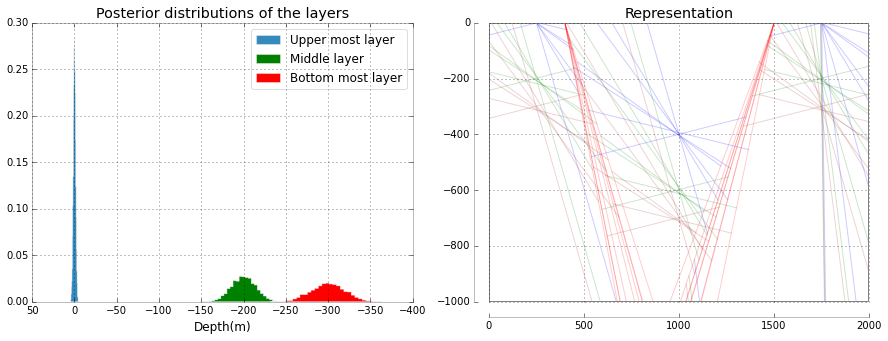

In [80]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].hist(alpha_samples_all, histtype='stepfilled', bins=30, alpha=1,
         label="Upper most layer", normed=True)
ax[0].hist(beta_samples_all, histtype='stepfilled', bins=30, alpha=1,
         label="Middle layer", normed=True, color = "g")
ax[0].hist(gamma_samples_all, histtype='stepfilled', bins=30, alpha=1,
         label="Bottom most layer", normed=True, color = "r")


ax[0].invert_xaxis()
ax[0].legend()
ax[0].set_title(r"""Posterior distributions of the layers""")
ax[0].set_xlabel("Depth(m)")


ax[1].set_title("Representation")
ax[1].set_xlim([0,2000])
ax[1].set_ylim([-1000,0])
for  alpha, beta, gamma, offset, layer_dip, fault_e_dip, fault_w_dip in parameters:
    #print alpha, beta, gamma
    model_parameters = {'faults' : {'fault_w_pos' : (400.,0.),
                                'fault_w_dip' : fault_w_dip,
                                'fault_e_pos' : (1500.,0.),
                                'fault_e_dip' : fault_e_dip},
                        'layers' : {3 : {'w' :(250., alpha),
                                                 'c' : (1000., alpha - offset),
                                                 'e' : (1750., alpha)},
                                    2 : {'w' :(250., beta),
                                                 'c' : (1000., beta-offset),
                                                 'e' : (1750., beta)},
                                    1 : {'w' :(250., gamma),
                                                 'c' : (1000., gamma - offset),
                                                 'e' : (1750., gamma)}},
                        'layer_dip' : layer_dip,
                        'layer_colors' : {1 : 'Brown', 2 : 'g', 3 : 'b'},
                        'width' : 2000., # [m]
                        'height' : 1000. # [m]
                        }
    GM = gs.GrabenModel(model_parameters)
    GM.plot_model(ax = ax[1], plot_faults= True , plot_points= False, alpha = 0.3) # Need to make it transparent!!!
    
    
    

In [39]:
def plot_figure(alpha, beta, gamma, offset, layer_dip, fault_e_dip, fault_w_dip, axe_position):
    #fig = plt.figure()
    #ax = fig.add_subplot(111)
    
    model_parameters = {'faults' : {'fault_w_pos' : (400.,0.),
                                'fault_w_dip' : fault_w_dip,
                                'fault_e_pos' : (1500.,0.),
                                'fault_e_dip' : fault_e_dip},
                        'layers' : {3 : {'w' :(250., alpha),
                                                 'c' : (1000., alpha - offset),
                                                 'e' : (1750., alpha)},
                                    2 : {'w' :(250., beta),
                                                 'c' : (1000., beta-offset),
                                                 'e' : (1750., beta)},
                                    1 : {'w' :(250., gamma),
                                                 'c' : (1000., gamma - offset),
                                                 'e' : (1750., gamma)}},
                        'layer_dip' : layer_dip,
                        'layer_colors' : {1 : 'Brown', 2 : 'g', 3 : 'b'},
                        'width' : 2000., # [m]
                        'height' : 1000. # [m]
                        }
    GM = gs.GrabenModel(model_parameters)
    GM.plot_model(ax = axe_position, plot_faults= True, plot_points= False, alpha = 1) # Need to make it transparent!!! 
    

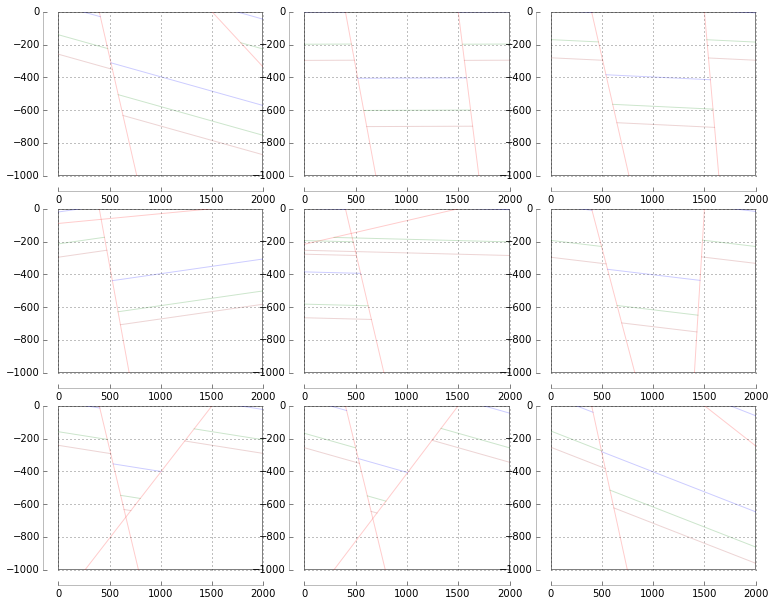

In [85]:
i = 0
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True)

for alpha, beta, gamma, offset, layer_dip, fault_e_dip, fault_w_dip  in parameters:
   # ax = fig.add_subplot(111)
    plot_figure(alpha, beta, gamma, offset, layer_dip, fault_e_dip, fault_w_dip, axs[i- 3*(i/3),i/3])
    axs[i- 3*(i/3),i/3].set_xlim([0,2000])
    axs[i- 3*(i/3),i/3].set_ylim([-1000,0])
    i += 1

In [ ]:
plot(M)

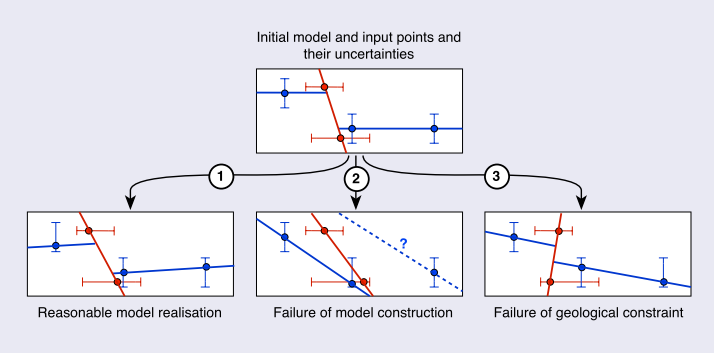

In [81]:
from IPython.core.display import Image
Image('Failures.png')

###Necessary constraints:
####Offset
- Negative offset makes no sense
- Higher values than the faults intersection

####Dipping
- Layers have to intersect in the 3 sectors: West, Center and East

#### Faults
- Numerical
 - The same as offset
 - Intersect -> same as dipping

- Geological
 - No more than 90º
 
### Adding complexity: Faults and slight inclination: Constraints